<a href="https://colab.research.google.com/github/gargarchit/PATE_Analysis/blob/master/Classification_of_MNIST_Digits_using_Differential_Privacy_and_performing_PATE_analysis_on_that_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>1. Loading MNIST Data</h2> 

In [0]:
import torch
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])]) #Grey Scale Image
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)  #private data
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)  #public data

In [0]:
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=64, shuffle=True)
mnist_testset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

In [0]:
from torch.utils.data import Subset
num_teachers = 100

teacher_loaders = []  #list of dataloaders

data_size = 600 # mnist_trainset/num_teachers

for i in range(num_teachers):
    
    indices = list(range(i*data_size, (i+1) *data_size))
    subset_data = Subset(mnist_trainset, indices)
    
    loader = torch.utils.data.DataLoader(subset_data, batch_size=64, num_workers=2)
    teacher_loaders.append(loader)


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

<h2>2. Visualize a Batch of Training Data</h2>

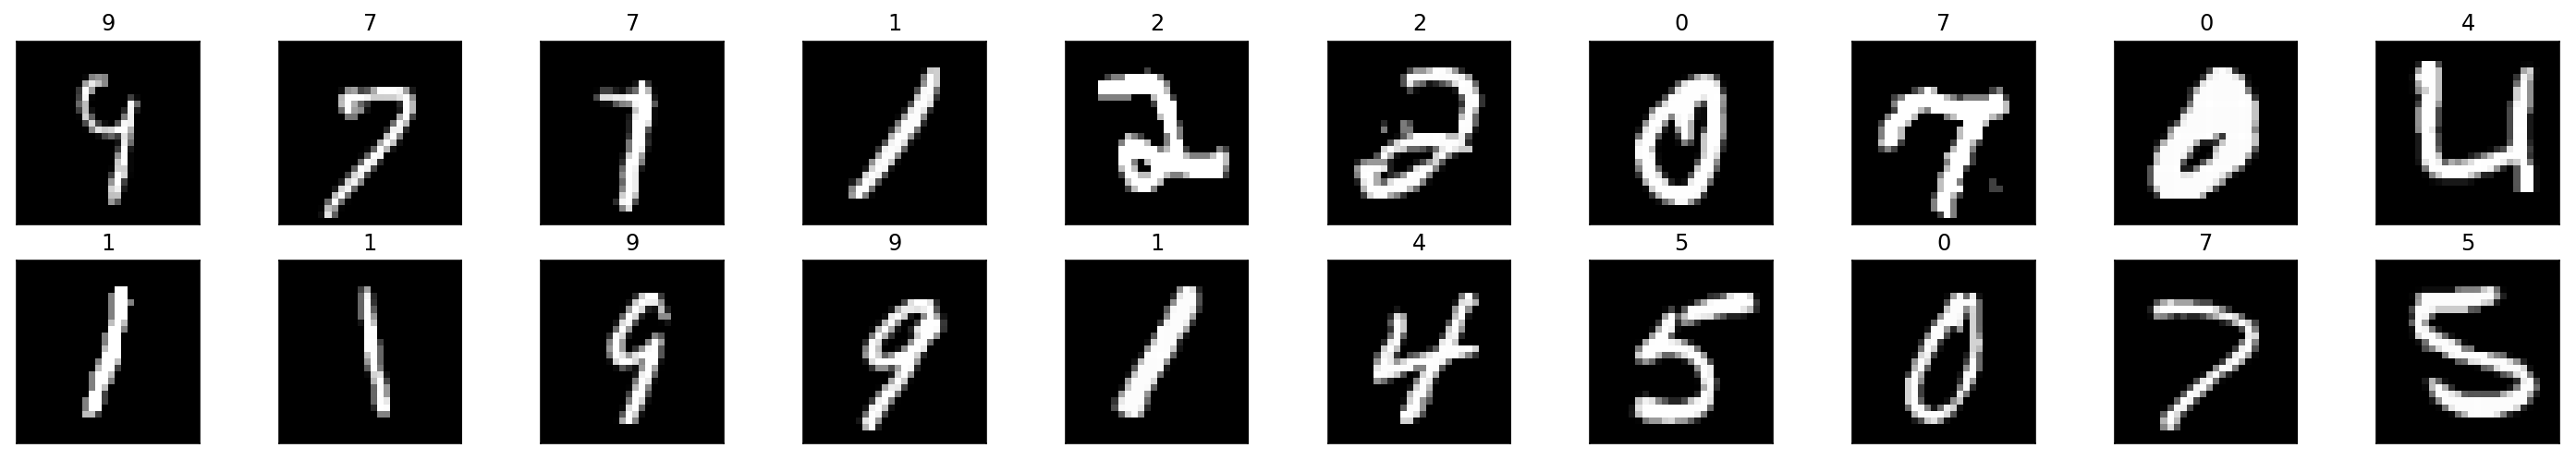

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

<h2>3. Network Architecture</h2> 

In [0]:
from torch import nn, optim
import torch.nn.functional as F

In [0]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        self.dropout = nn.Dropout(p=0.2) # Dropout module with 0.2 drop probability

    def forward(self, x):
        x = x.view(x.shape[0], -1)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        x = F.log_softmax(self.fc4(x), dim=1)

        return x

<h2>4. Training the Network</h2> 


In [0]:
epochs = 10
models = []
model = Classifier()
model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
teacher_loss = []
for i in range(num_teachers):

    running_loss = 0
    for e in range(epochs):
        running_loss = 0
        for images, labels in teacher_loaders[i]:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    teacher_loss.append(running_loss)
    print("Loss {} : {}".format(i+1, running_loss))
    models.append(model)

Loss 1 : 18.301589012145996
Loss 2 : 12.003913462162018
Loss 3 : 8.129547894001007
Loss 4 : 5.668042421340942
Loss 5 : 5.030676394701004
Loss 6 : 4.753865748643875
Loss 7 : 4.186972439289093
Loss 8 : 3.982820510864258
Loss 9 : 4.132578343153
Loss 10 : 3.293241299688816
Loss 11 : 2.7865162193775177
Loss 12 : 3.509065017104149
Loss 13 : 3.1600179225206375
Loss 14 : 3.1747706159949303
Loss 15 : 4.0667904317379
Loss 16 : 3.0144488736987114
Loss 17 : 2.5798023343086243
Loss 18 : 2.109486535191536
Loss 19 : 2.2188277691602707
Loss 20 : 2.7345967888832092
Loss 21 : 2.5215380787849426
Loss 22 : 3.3612343668937683
Loss 23 : 2.2011071369051933
Loss 24 : 3.0905313938856125
Loss 25 : 2.3924371749162674
Loss 26 : 1.8592048436403275
Loss 27 : 2.3230913057923317
Loss 28 : 2.0204626619815826
Loss 29 : 1.6881142929196358
Loss 30 : 2.2828224413096905
Loss 31 : 1.5411053225398064
Loss 32 : 1.530673049390316
Loss 33 : 1.5008613094687462
Loss 34 : 1.8895871825516224
Loss 35 : 2.118949942290783
Loss 36 : 1.

In [0]:
#Creating the public dataset
student_traindata = Subset(mnist_testset, list(range(9000)))
student_testdata = Subset(mnist_testset, list(range(9000, 10000)))

In [0]:
student_trainloader = torch.utils.data.DataLoader(student_traindata, batch_size=64, shuffle=True)
student_testloader = torch.utils.data.DataLoader(student_testdata, batch_size=64, shuffle=True)


In [0]:

def perdict(model, dataloader):
    outputs = torch.zeros(0, dtype=torch.long).to(device)
    model.to(device)
    model.eval()
    for image, labels in dataloader:
        image, labels = image.to(device), labels.to(device)  
        output = model(image)
        ps = torch.argmax(torch.exp(output), dim=1)
        outputs = torch.cat((outputs, ps))
    return outputs

In [0]:
epsilon = 0.1
preds = torch.zeros((len(models),9000), dtype=torch.long)
for i, model in enumerate(models):
    results = perdict(model, student_trainloader)
    preds[i] = results
labels = np.array([]).astype(int)
for image_preds in np.transpose(preds):  
    label_counts = np.bincount(image_preds, minlength = 10)
    beta = 1/ epsilon
    for i in range(len(label_counts)):
        label_counts[i] += np.random.laplace(0, beta, 1)
    new_label = np.argmax(label_counts)
    labels = np.append(labels, new_label)

In [0]:
student_labels = np.array(labels)
preds = preds.numpy()

In [0]:
print(student_labels)
print()
print(preds)

[5 4 9 ... 2 4 6]

[[9 9 7 ... 3 6 4]
 [4 0 4 ... 3 0 9]
 [3 7 6 ... 4 5 8]
 ...
 [0 6 2 ... 8 4 6]
 [7 7 8 ... 7 8 8]
 [6 4 8 ... 0 2 8]]


**Creating student model and training it with the label generated from last step**

In [0]:
epochs = 50
train_losses, test_losses = [], []
model = Classifier()
model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
running_loss = 0
for e in range(epochs):
    running_loss = 0
    for images, labels in student_trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            for images, labels in student_testloader:
                images, labels = images.to(device), labels.to(device)
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))        
        train_losses.append(running_loss/len(student_trainloader))
        test_losses.append(test_loss/len(student_testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(student_trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(student_testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(student_testloader)))
    

Epoch: 1/50..  Training Loss: 2.031..  Test Loss: 1.531..  Test Accuracy: 0.548
Epoch: 2/50..  Training Loss: 1.153..  Test Loss: 0.920..  Test Accuracy: 0.706
Epoch: 3/50..  Training Loss: 0.770..  Test Loss: 0.744..  Test Accuracy: 0.757
Epoch: 4/50..  Training Loss: 0.630..  Test Loss: 0.642..  Test Accuracy: 0.801
Epoch: 5/50..  Training Loss: 0.553..  Test Loss: 0.550..  Test Accuracy: 0.834
Epoch: 6/50..  Training Loss: 0.489..  Test Loss: 0.520..  Test Accuracy: 0.842
Epoch: 7/50..  Training Loss: 0.459..  Test Loss: 0.489..  Test Accuracy: 0.850
Epoch: 8/50..  Training Loss: 0.413..  Test Loss: 0.479..  Test Accuracy: 0.853
Epoch: 9/50..  Training Loss: 0.397..  Test Loss: 0.445..  Test Accuracy: 0.871
Epoch: 10/50..  Training Loss: 0.366..  Test Loss: 0.418..  Test Accuracy: 0.880
Epoch: 11/50..  Training Loss: 0.348..  Test Loss: 0.424..  Test Accuracy: 0.871
Epoch: 12/50..  Training Loss: 0.330..  Test Loss: 0.383..  Test Accuracy: 0.883
Epoch: 13/50..  Training Loss: 0.309.

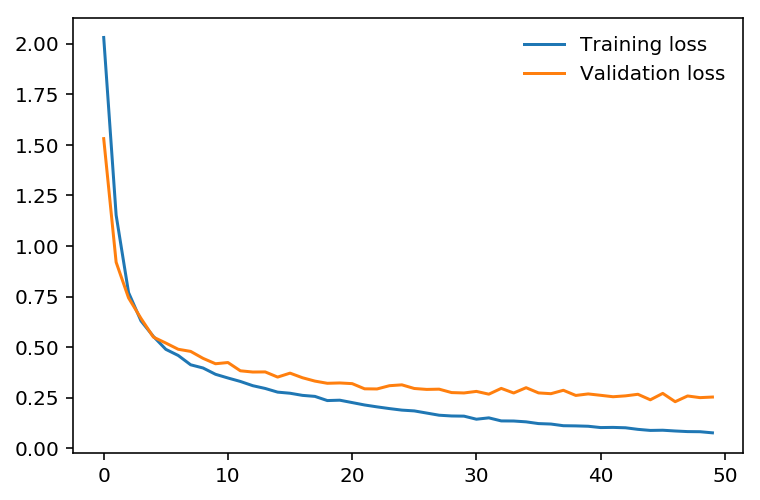

In [0]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [0]:
print("Accuracy obtained: {:.3f}%".format(accuracy/len(student_testloader)*100))

Accuracy obtained: 93.711%


<h2>5. Installing and importing PySyft</h2> 

In [0]:
!pip install tf-encrypted

! URL="https://github.com/openmined/PySyft.git" && FOLDER="PySyft" && if [ ! -d $FOLDER ]; then git clone -b dev --single-branch $URL; else (cd $FOLDER && git pull $URL && cd ..); fi;

!cd PySyft; python setup.py install  > /dev/null

import os
import sys
module_path = os.path.abspath(os.path.join('./PySyft'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
!pip install --upgrade --force-reinstall lz4
!pip install --upgrade --force-reinstall websocket
!pip install --upgrade --force-reinstall websockets
!pip install --upgrade --force-reinstall zstd

     |████████████████████████████████| 1.4MB 4.9MB/s 
     |████████████████████████████████| 276kB 62.6MB/s 
  Stored in directory: /root/.cache/pip/wheels/16/27/a1/775c62ddea7bfa62324fd1f65847ed31c55dadb6051481ba3f
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Cloning into 'PySyft'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 26853 (delta 11), reused 13 (delta 6), pack-reused 26821
Receiving objects: 100% (26853/26853), 31.65 MiB | 29.41 MiB/s, done.
Resolving deltas: 100% (17532/17532), done.
zip_safe flag not set; analyzing archive contents...
zip_safe flag not set; analyzing archive contents...
__pycache__.zstd.cpython-36: module references __file__
     |████████████████████████████████| 389kB 4.8MB/s 
ERROR: syft 0.1.19a1 has requirement msgpack>=0.6.1, but you'll have msgpack 0.

In [0]:
from syft.frameworks.torch.differential_privacy import pate

In [0]:
data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=preds, indices=student_labels, noise_eps=epsilon, delta=1e-5, moments=20)
print("Data Independent Epsilon:", data_ind_eps)
print("Data Dependent Epsilon:", data_dep_eps)

Data Independent Epsilon: 371.5129254649703
Data Dependent Epsilon: 371.5129254650068
